In [2]:
import pandas as pd
import numpy as np
import pickle

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch

In [4]:
from sklearn.decomposition import PCA
import umap

In [5]:
df = pd.read_csv(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/processed/processed_reviews.csv"
)

In [6]:
df.head()

,rating,review_length_text,review_length_title,polarity_text,polarity_title,subjectivity_text,subjectivity_title,lemmatized_text,lemmatized_title,day_of_week,month,year
0,1,408,2,0.018448,-1.0,0.512241,1.0,"['travel', 'lot', 'travel', 'often', 'last', '...","['bad', 'airline']",Wednesday,11,2024
1,1,157,4,-0.060897,-1.0,0.592949,1.0,"['review', 'regard', 'flight', 'af', 'book', '...","['terrible', 'experience', 'airfrance']",Wednesday,11,2024
2,1,259,11,-0.094163,-0.6,0.488287,0.7,"['recently', 'fly', 'air', 'france', 'flight',...","['extremely', 'disappointing', 'experience', '...",Tuesday,11,2024
3,1,274,1,-0.109373,-1.0,0.494012,1.0,"['wow', 'horrible', 'experience', 'I', 've', '...",['horrible'],Monday,11,2024
4,1,311,7,-0.126476,-1.0,0.485192,1.0,"['spend', 'fantastic', 'day', 'vacation', 'hon...","['bad', 'flight', 'experience', 'I', 've', 'ev...",Monday,11,2024


In [7]:
bow_vectorizer = CountVectorizer(max_features=10000, min_df=5, stop_words="english")
X_bow = bow_vectorizer.fit_transform(df["lemmatized_text"].astype(str))

df_bow = pd.DataFrame(X_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

with open('/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bow_vectorized.pkl', 'wb') as f:
    pickle.dump(df_bow, f)

df_bow.head()

,ability,able,aboard,absolute,absolutely,ac,accent,accept,acceptable,access,...,yes,yesterday,yogurt,york,young,yr,yvr,zero,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000, 
    stop_words="english", 
    ngram_range=(1,2), 
    min_df=5, 
)

# Fit and transform lemmatized text
X_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_text'].astype(str))
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Save TF-IDF matrix
with open('/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/tfidf_vectorized.pkl', 'wb') as f:
    pickle.dump(df_tfidf, f)


df_tfidf.head()

,ability,able,able check,able fly,able sleep,able stretch,aboard,absolute,absolutely,ac,...,yesterday,yogurt,york,young,yr,yr old,yvr,zero,zone,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
tokenized_reviews = [text.split() for text in df["lemmatized_text"].astype(str)]

word2vec_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

def get_word2vec_embeddings(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

df['word2vec_embedding'] = df['lemmatized_text'].apply(get_word2vec_embeddings)

# Convert embeddings to a list (needed for pickle)
word2vec_embeddings = df['word2vec_embedding'].tolist()

# Save Word2Vec embeddings
word2vec_path = '/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_vectorized.pkl'
with open(word2vec_path, 'wb') as f:
    pickle.dump(word2vec_embeddings, f)

print(f"Word2Vec embeddings successfully saved to {word2vec_path}")

df[['word2vec_embedding']].head()

Word2Vec embeddings successfully saved to /home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_vectorized.pkl


,word2vec_embedding
0,"[-0.3482372, 0.1485831, 0.040150277, -0.131093..."
1,"[-0.22456235, 0.28886646, 0.016860025, -0.0654..."
2,"[-0.21611068, 0.28302014, 0.041171674, 0.03966..."
3,"[-0.24007133, 0.27345255, 0.023952367, -0.0746..."
4,"[-0.2581199, 0.1853706, 0.03319416, -0.0235828..."


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

def get_bert_embeddings(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:,0,:].cpu().numpy().flatten()

df['bert_embedding'] = df['lemmatized_text'].apply(get_bert_embeddings)

with open('/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bert_vectorized.pkl', 'wb') as f:
    pickle.dump(df['bert_embedding'].tolist(), f)
    
print("BERT embeddings successfully saved to bert_vectorized.pkl")

df[['bert_embedding']].head()

BERT embeddings successfully saved to bert_vectorized.pkl


,bert_embedding
0,"[-0.059372894, 0.87842745, 0.42169085, 0.00433..."
1,"[-0.22069171, 0.65713084, 0.33688197, -0.20024..."
2,"[-0.28149357, 0.7224497, 0.23585524, -0.108056..."
3,"[-0.10413745, 0.7803177, 0.3849645, -0.0113108..."
4,"[-0.17919672, 0.6800731, 0.50333893, -0.045008..."


In [11]:
from sklearn.decomposition import PCA
import umap

In [20]:
pca = PCA(n_components=100)
X_tfidf_pca = pca.fit_transform(df_tfidf)

In [13]:
umap_model = umap.UMAP(n_components=2)
X_word2vec_umap = umap_model.fit_transform(df['word2vec_embedding'].tolist())

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
with open("/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/tfidf_pca.pkl", "wb") as f:
    pickle.dump(Xtfidfd, f)
    
with open("/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_umap.pkl", "wb") as f:
    pickle.dump(X_word2vec_umap, f)


In [22]:
df_final_vectorized = pd.DataFrame({
    "tfidf_pca" : list(X_tfidf_pca),
    "word2vec_umap" : list(X_word2vec_umap),
    "bert_embedding" : list(df['bert_embedding'])
})

with open("/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/vectorized_text.pkl", "wb") as f:
    pickle.dump(df_final_vectorized, f)

df_final_vectorized.head()

,tfidf_pca,word2vec_umap,bert_embedding
0,"[-0.2983993548245981, 0.07848125831351287, -0....","[9.268281, 8.026937]","[-0.059372894, 0.87842745, 0.42169085, 0.00433..."
1,"[0.031506038483555654, -0.05425399239442684, 0...","[4.0126038, 9.127553]","[-0.22069171, 0.65713084, 0.33688197, -0.20024..."
2,"[-0.019186652689684086, 0.027815003901052373, ...","[3.4398975, 7.825716]","[-0.28149357, 0.7224497, 0.23585524, -0.108056..."
3,"[-0.02259170715527356, 0.027241425719442335, 0...","[4.4891686, 8.070519]","[-0.10413745, 0.7803177, 0.3849645, -0.0113108..."
4,"[-0.04497322998076532, 0.008552786942138742, 0...","[6.4680376, 8.592912]","[-0.17919672, 0.6800731, 0.50333893, -0.045008..."


In [23]:
print(f"TF-IDF Shape: {df_tfidf.shape}")

df_tfidf.head()

TF-IDF Shape: (2560, 4455)


,ability,able,able check,able fly,able sleep,able stretch,aboard,absolute,absolutely,ac,...,yesterday,yogurt,york,young,yr,yr old,yvr,zero,zone,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words="english", 
    ngram_range=(1,2), 
    min_df=5)
vectorizer.fit(df['lemmatized_text'].astype(str))

feature_names = vectorizer.get_feature_names_out()
word_importance = df_tfidf.sum(axis=0) 

df_tfidf_importance = pd.DataFrame({"word" : feature_names, 'importance' : word_importance})
df_tfidf_importance.sort_values(by='importance', ascending=False).head(20)



,word,importance
flight,flight,155.459244
air,air,106.271317
france,france,102.776753
air france,air france,98.063222
seat,seat,90.306813
good,good,85.757424
service,service,81.538649
fly,fly,76.047315
time,time,73.944200
food,food,73.272631


In [29]:
word2vec_model.save("/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_model.bin")

In [35]:
similar_words = [word.strip("[]' ") for word in word2vec_model.wv.index_to_key if "serv" in word]
print(similar_words)


["service',", "serve',", "reservation',", 'service', "reserve',", "service',", "deserve',", "observe',", 'serve']


In [36]:
print("service" in word2vec_model.wv.key_to_index)  # Should return True or False

False


In [37]:
print(word2vec_model.wv.index_to_key[:20])

["'flight',", "'air',", "'france',", "'seat',", "'service',", "'not',", "'get',", "'time',", "'good',", "'paris',", "'fly',", "'food',", "'hour',", "'we',", "'airline',", "'would',", "'one',", "'do',", "'go',", "'plane',"]


In [38]:
print(type(df["lemmatized_text"].iloc[0]))  # Check if it's a list or string

<class 'str'>


In [39]:
import ast  # Helps convert strings to lists safely

df["lemmatized_text"] = df["lemmatized_text"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [40]:
from gensim.models import Word2Vec

# Ensure every review is a list of words (not a string!)
sentences = df["lemmatized_text"].tolist()

# Train Word2Vec Model
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save Model
word2vec_model.save("../data/interim/word2vec_model.bin")


In [41]:
word2vec_model = Word2Vec.load("../data/interim/word2vec_model.bin")

# Now check the first few words
print(word2vec_model.wv.index_to_key[:20])  # Should be clean words

# Check for a word again
print("service" in word2vec_model.wv.key_to_index)  # Should return True


['flight', 'air', 'france', 'seat', 'service', 'fly', 'not', 'time', 'get', 'good', 'paris', 'food', 'airline', 'hour', 'we', 'would', 'do', 'one', 'go', 'plane']
True


In [42]:
import pickle

# Define paths
vector_files = {
    "TF-IDF": "../data/interim/tfidf_vectorized.pkl",
    "TF-IDF PCA": "../data/interim/tfidf_pca.pkl",
    "BoW": "../data/interim/bow_vectorized.pkl",
    "Word2Vec": "../data/interim/word2vec_vectorized.pkl",
    "Word2Vec UMAP": "../data/interim/word2vec_umap.pkl",
    "BERT": "../data/interim/bert_vectorized.pkl",
    "Vectorized Text": "../data/interim/vectorized_text.pkl"
}

# Load and check each file
for name, path in vector_files.items():
    try:
        with open(path, "rb") as f:
            data = pickle.load(f)
        print(f"\n{name} Shape: {data.shape if hasattr(data, 'shape') else len(data)}")
    except Exception as e:
        print(f"Error loading {name}: {e}")


TF-IDF Shape: (2560, 4455)

TF-IDF PCA Shape: (2560, 100)

BoW Shape: (2560, 2193)

Word2Vec Shape: 2560

Word2Vec UMAP Shape: (2560, 2)

BERT Shape: 2560

Vectorized Text Shape: (2560, 3)


In [44]:
key_terms = ["service", "food", "seat", "entertainment", "cabin", "crew", "flight", "airline", "pilot", "plane", "delay"]

for term in key_terms:
    if term in word2vec_model.wv.key_to_index:
        print(f"\nMost similar words to '{term}':")
        print(word2vec_model.wv.most_similar(term, topn=5))
    else:
        print(f"\n '{term}' not found in Word2Vec model")


Most similar words to 'service':
[('excellent', 0.98540198802948), ('quality', 0.9813424944877625), ('great', 0.9797899723052979), ('good', 0.9740332365036011), ('friendly', 0.9734148979187012)]

Most similar words to 'food':
[('good', 0.9949831366539001), ('entertainment', 0.9942781925201416), ('excellent', 0.9861153960227966), ('great', 0.9832167029380798), ('friendly', 0.9828421473503113)]

Most similar words to 'seat':
[('recline', 0.9798411726951599), ('room', 0.9744508266448975), ('leg', 0.9687697887420654), ('duo', 0.9679466485977173), ('space', 0.962651252746582)]

Most similar words to 'entertainment':
[('food', 0.9942781925201416), ('meal', 0.9897358417510986), ('good', 0.986778974533081), ('selection', 0.9862539172172546), ('wine', 0.9857098460197449)]

Most similar words to 'cabin':
[('clean', 0.9937268495559692), ('attentive', 0.9920470714569092), ('selection', 0.9913048148155212), ('nice', 0.9908360242843628), ('wine', 0.9899007678031921)]

Most similar words to 'crew':


In [47]:
with open('/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bert_vectorized.pkl','rb') as f:
    df_bert = pickle.load(f)
    
print(f'BERT Shape: {len(df_bert)} rows, {len(df_bert[0])}  dimensions')

df_bert[0][:10]

BERT Shape: 2560 rows, 768  dimensions


array([-0.05937289,  0.87842745,  0.42169085,  0.00433695,  0.1075745 ,
        0.6392341 ,  0.62086517,  1.1772614 , -0.19186631,  0.08315764],
      dtype=float32)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([df_bert[0]], [df_bert[1]])[0][0]

0.92086643

In [49]:
print(f"TF-IDF PCA Shape: {X_tfidf_pca.shape}")

TF-IDF PCA Shape: (2560, 100)


In [50]:
pca = PCA(n_components=100)
pca.fit(df_tfidf)

PCA(n_components=100)

In [51]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by first 100 components: {explained_variance[-1]*100:.2f}%")

Variance explained by first 100 components: 25.04%


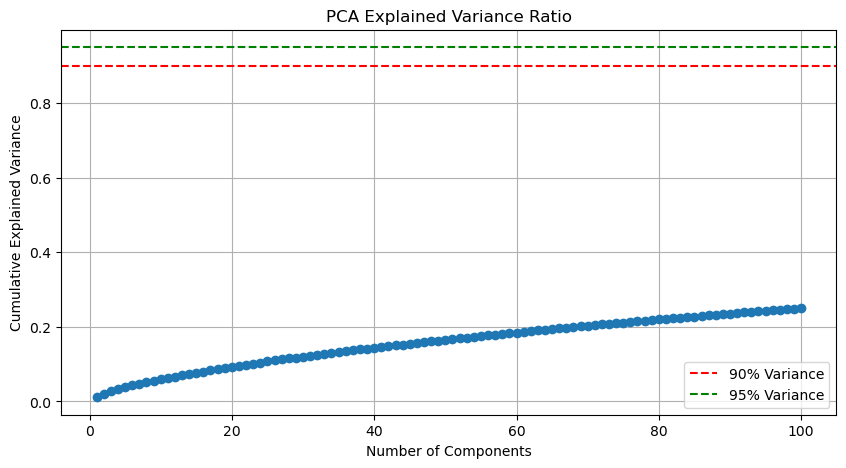

In [52]:
import matplotlib.pyplot as plt

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot variance vs number of components
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--")
plt.axhline(y=0.90, color="r", linestyle="--", label="90% Variance")
plt.axhline(y=0.95, color="g", linestyle="--", label="95% Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Ratio")
plt.legend()
plt.grid()
plt.show()


In [53]:
# Find the minimum number of components needed for 90% and 95% variance
n_components_90 = np.argmax(explained_variance >= 0.90) + 1
n_components_95 = np.argmax(explained_variance >= 0.95) + 1

print(f"Minimum components for 90% variance: {n_components_90}")
print(f"Minimum components for 95% variance: {n_components_95}")


Minimum components for 90% variance: 1
Minimum components for 95% variance: 1


In [54]:
optimal_components = n_components_90  # Use n_components_95 if needed
pca_optimal = PCA(n_components=optimal_components)
X_tfidf_pca_optimal = pca_optimal.fit_transform(df_tfidf)

# Save updated PCA-transformed data
import pickle
with open("../data/interim/tfidf_pca.pkl", "wb") as f:
    pickle.dump(X_tfidf_pca_optimal, f)

print(f"TF-IDF PCA Shape with {optimal_components} components: {X_tfidf_pca_optimal.shape}")


TF-IDF PCA Shape with 1 components: (2560, 1)


In [55]:
import umap
reducer = umap.UMAP(n_components=2, random_state=42)
X_tfidf_umap = reducer.fit_transform(df_tfidf)

print(f"TF-IDF UMAP Shape: {X_tfidf_umap.shape}")


/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


TF-IDF UMAP Shape: (2560, 2)


In [56]:
with open("../data/interim/tfidf_umap.pkl", "wb") as f:
    pickle.dump(X_tfidf_umap, f)
print(f"TF-IDF UMAP Data Saved! Shape: {X_tfidf_umap.shape}")

TF-IDF UMAP Data Saved! Shape: (2560, 2)


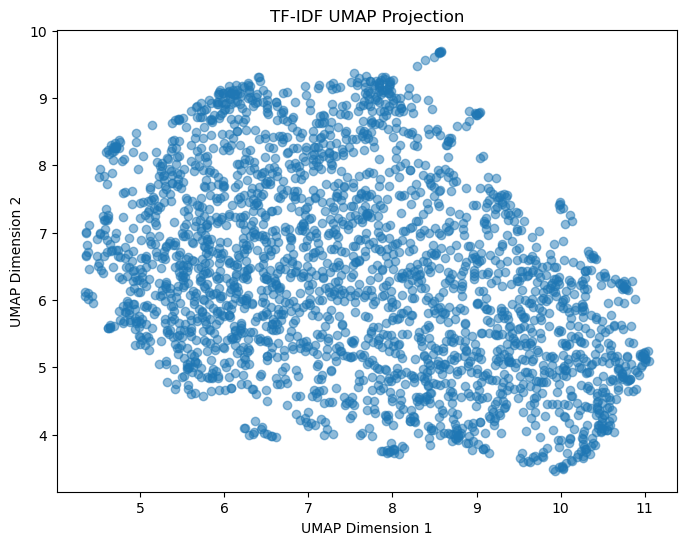

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tfidf_umap[:, 0], X_tfidf_umap[:, 1], alpha=0.5)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("TF-IDF UMAP Projection")
plt.show()

In [58]:

with open("../data/interim/word2vec_umap.pkl", "rb") as f:
    X_word2vec_umap = pickle.load(f)

print(f"Word2Vec UMAP Shape: {X_word2vec_umap.shape}")

Word2Vec UMAP Shape: (2560, 2)


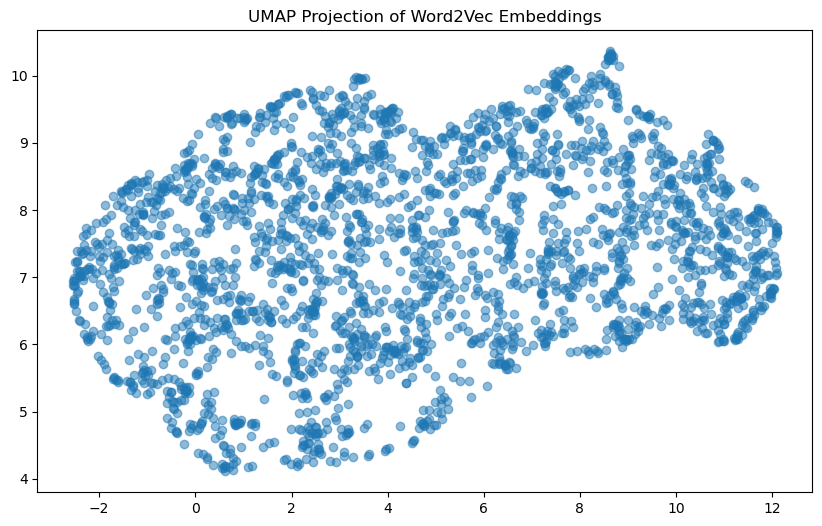

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(X_word2vec_umap[:, 0], X_word2vec_umap[:, 1], alpha=0.5)
plt.title("UMAP Projection of Word2Vec Embeddings")
plt.show()

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


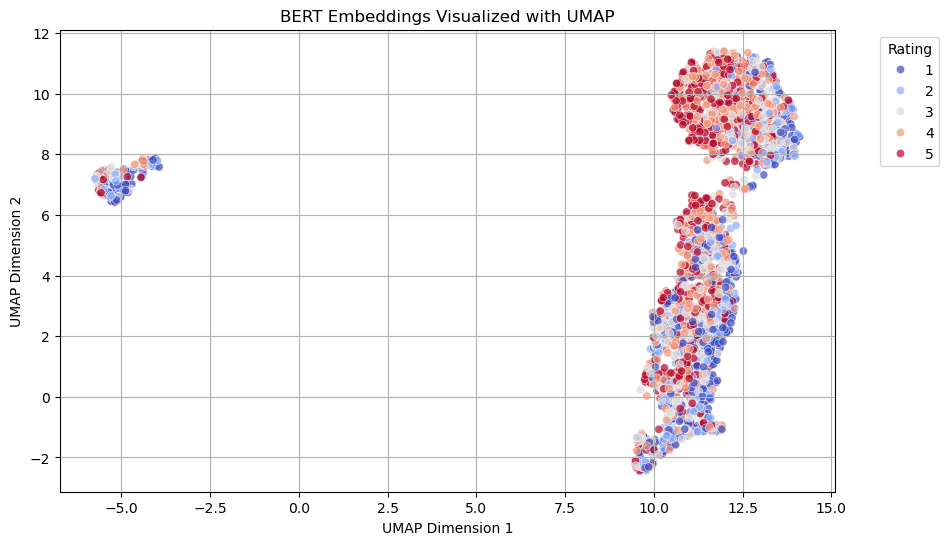

In [62]:
import seaborn as sns

reducer = umap.UMAP(n_components=2, random_state =42)
bert_umap =reducer.fit_transform(df_bert)

# Load the original dataset to get sentiment/ratings
df_reviews_path = "../data/processed/processed_reviews.csv"  # Adjust if needed
df_reviews = pd.read_csv(df_reviews_path)

# Ensure same length
df_reviews = df_reviews.iloc[:len(bert_umap)]

# Plot the UMAP representation
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=bert_umap[:, 0], y=bert_umap[:, 1], 
    hue=df_reviews["rating"], palette="coolwarm", alpha=0.7
)
plt.title("BERT Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


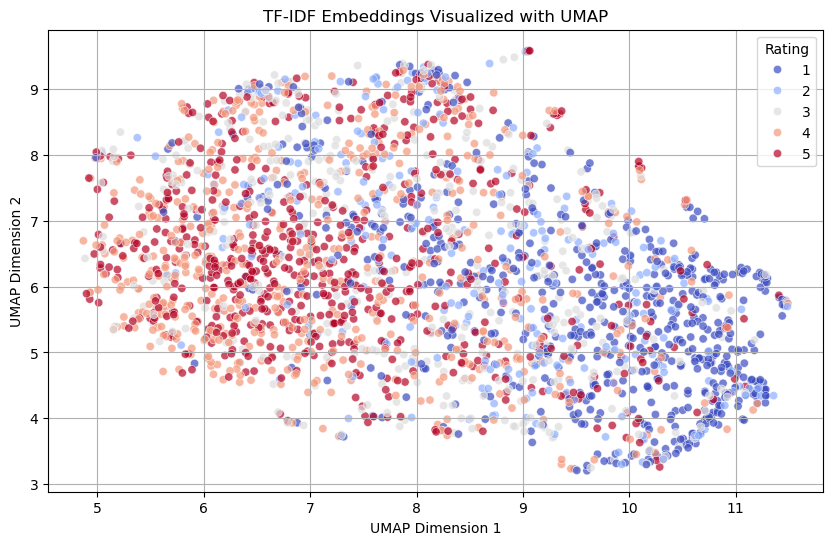

In [63]:
# Load the ratings data (ensuring alignment)
df_processed = pd.read_csv("../data/processed/processed_reviews.csv")
ratings = df_processed["rating"]

# Apply UMAP to reduce TF-IDF dimensions to 2D
reducer_tfidf = umap.UMAP(n_components=2, random_state=42)
X_tfidf_umap = reducer_tfidf.fit_transform(X_tfidf)

# Plot UMAP for TF-IDF embeddings
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tfidf_umap[:, 0], y=X_tfidf_umap[:, 1], hue=ratings, palette="coolwarm", alpha=0.7)
plt.title("TF-IDF Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating")
plt.grid()
plt.show()

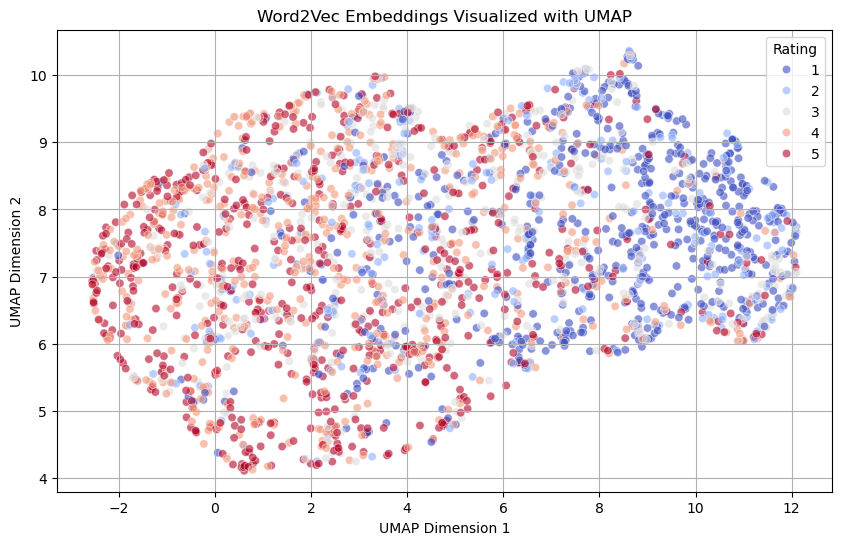

In [64]:
# Load Word2Vec UMAP embeddings
with open("../data/interim/word2vec_umap.pkl", "rb") as f:
    X_word2vec_umap = pickle.load(f)

# Load dataset to get ratings for coloring
df_processed = pd.read_csv("../data/processed/processed_reviews.csv")

# Ensure we have the correct number of rows
if X_word2vec_umap.shape[0] != df_processed.shape[0]:
    raise ValueError("Mismatch between embeddings and dataset size!")

# Plot UMAP visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_word2vec_umap[:, 0],
    y=X_word2vec_umap[:, 1],
    hue=df_processed["rating"],
    palette="coolwarm",
    alpha=0.6
)
plt.title("Word2Vec Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating", loc="upper right")
plt.grid(True)
plt.show()